In [47]:
%matplotlib inline
import glob
import pandas as pd
import mne
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import autosklearn.regression
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import multiprocessing

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import pickle
from wavelets import WaveletAnalysis
from tensorflow.keras import layers

In [2]:
experiment = 'data/original/*/*'

In [3]:
meps = sorted(glob.glob(experiment + '/mep/*/*.txt'))
mep_present = len(meps) > 0
eegs = sorted(glob.glob(experiment + '/eeg/*/clean.set'))
eeg_present = len(eegs) > 0
all_present = mep_present and eeg_present
print(all_present)

True


In [4]:
eegs = [
    'data/original/sub01/exp01/eeg/SP 110RMT r1/clean.set',
    'data/original/sub03/exp01/eeg/SP 110RMT r1/clean.set',
    'data/original/sub04/exp01/eeg/SP 110RMT r1/clean.set',
    'data/original/sub05/exp01/eeg/SP 110RMT r3/clean.set',
    'data/original/sub06/exp01/eeg/SP 110RMT r1/clean.set',
    'data/original/sub07/exp01/eeg/SP 110RMT r1/clean.set',
    'data/original/sub08/exp01/eeg/SP 110RMT r1/clean.set',
    'data/original/sub10/exp01/eeg/SP 110RMT/clean.set',
    'data/original/sub11/exp01/eeg/SP 110RMT/clean.set',
    'data/original/sub13/exp01/eeg/SP 110RMT/clean.set'
]

In [5]:
# Read EEG file and prepare epochs in dataframes.
def read_eeg(path):
    epochs = read_epochs_eeglab(path)
    epochs = epochs.pick_channels(ch_names=['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'EOG', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz'])
    epoch_list = []
    i = 0
    for epoch in epochs.iter_evoked():
        df = epoch.to_data_frame()
        epoch_list.append(df)
    return epoch_list

In [6]:
# Select EEG before TMS.
def crop_epochs(epoch_list, duration_millis=500, sampling_rate=1000):
    new_epoch_list = []
    for epoch_df in epoch_list:
        # Delete EEG after TMS event.
        epoch_df['signal time'] = epoch_df.index
        epoch_df = epoch_df.reset_index()
        indices = epoch_df.index[epoch_df['signal time'] == 0].tolist()
        event_index = int(len(indices)/2)
        delete_count = epoch_df.shape[0] - indices[event_index]
        epoch_df = epoch_df.drop(epoch_df.tail(delete_count).index)

        # Select EEG for the selected duration.
        keep = int(duration_millis * sampling_rate / 1000)
        delete_count = epoch_df.shape[0] - keep
        epoch_df = epoch_df.drop(epoch_df.head(delete_count).index)

        # Append the epoch in the list.
        epoch_df = epoch_df.set_index('signal time')
        new_epoch_list.append(epoch_df)
    return new_epoch_list, -keep

In [7]:
# Open MEP file as dataframe.
def open_mep_as_df(path):
    fileMep = open(path, "r+")
    mep_frames = fileMep.read().split('\n\n')
    df_list = []
    for mep_frame in mep_frames:
        df_list.append(pd.read_csv(StringIO(mep_frame), '\t'))
    return df_list

In [8]:
# Function to get APB column name.
def get_apb_column_name(mep_frame):
    if 'L APB' in mep_frame:
        return 'L APB'
    else:
        return 'APB'

In [9]:
# Function to crop MEP region.
def crop_mep_region(mep_frame):
    crop_start = 0.211
    crop_end = 0.4
    multiplier = 7499 / 1.4998
    start = int(crop_start * multiplier)
    end = int(crop_end * multiplier)
    mep_cropped = mep_frame.iloc[start:end, :]
    time = mep_frame.iloc[start:end, :]
    return mep_cropped, time

In [10]:
# Calculate MEP size.
def calculate_mep_size(mep_frame):
    mep_cropped, time = crop_mep_region(mep_frame)
    apb_name = get_apb_column_name(mep_frame)
    max_row = mep_frame.iloc[mep_cropped.idxmax(axis=0)[apb_name]]
    min_row = mep_frame.iloc[mep_cropped.idxmin(axis=0)[apb_name]]
    mep_size = max_row[apb_name] - min_row[apb_name]
    return mep_size

In [11]:
# Calculate EEG area.
def calculate_eeg_area(epoch_df):
    gfp = np.sum(epoch_df ** 2, axis=1)
    times = gfp.index
    gfp = mne.baseline.rescale(gfp.values, times, baseline=(None, 0))
    return np.trapz(gfp, times)

In [12]:
# Calculate EEG frequency.
def calculate_eeg_frequency(channel):
    sf = 1000
    win = 4 * sf
    freqs, psd = signal.welch(channel, sf, nperseg=win)
    return freqs, psd

In [13]:
def calculate_eeg_max_amplitude(epoch_df):
    avg = epoch_df.mean(axis=1)
    return np.max(avg.values)

In [14]:
def filter_electrodes(epoch, which='lm1'):
    if which == 'ltm1':
        return epoch.drop(['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC2',
                'FC6', 'M1', 'T7', 'Cz', 'C4', 'T8', 'M2', 'CP2',
                'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'EOG', 'AF7',
                'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FCz', 'FC4',
                'C2', 'C6', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3',
                'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz'], axis=1)
    else:
        return epoch.drop(['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1',
                'M1', 'T7', 'C3', 'Cz', 'T8', 'M2', 'CP5', 'CP1',
                'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'EOG', 'AF7',
                'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'C5',
                'C1', 'CP3', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3',
                'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz'], axis=1)

In [15]:
def band_max(freq, psd, start=0, end=4):
    start = np.where(freq==start)
    if len(start) > 0:
        start = start[0][0]
    else:
        start = 0
    end = np.where(freq==end)
    if len(end) > 0:
        end = end[0][0]
    else:
        end = start + 4
    freq = freq[start:end]
    psd = psd[start:end]
    i = np.argmax(np.abs(psd))
    return freq[i], psd[i]

In [23]:
def prepare_wavelet(signal):
    wa = WaveletAnalysis(signal, dt=1)
    power = wa.wavelet_power
    scales = wa.scales
    t = wa.time
    return power

In [21]:
epochs = read_eeg(eeg_path)
epochs, _ = crop_epochs(epochs)

Extracting parameters from data/original/sub03/exp01/eeg/SP 110RMT r1/clean.set...
50 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.

In [56]:
signal = epochs[5].drop('time', axis=1)
signal = signal.mean(axis=1)
wa = WaveletAnalysis(signal.values, dt=1)
power = wa.wavelet_power
scales = wa.scales
t = wa.time

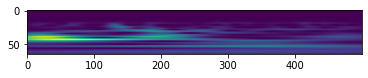

In [45]:
plt.imshow(power)

In [89]:
def fig2data ( fig ):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw ( )
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.fromstring ( fig.canvas.tostring_argb(), dtype=np.uint8 )
    buf.shape = ( w, h,4 )
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll ( buf, 3, axis = 2 )
    return buf

In [90]:
def fig2img ( fig ):
    # put the figure pixmap into a numpy array
    buf = fig2data ( fig )
    w, h, d = buf.shape
    return Image.fromstring( "RGBA", ( w ,h ), buf.tostring( ) )

In [92]:
import Image

ModuleNotFoundError: No module named 'Image'

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


NameError: name 'Image' is not defined

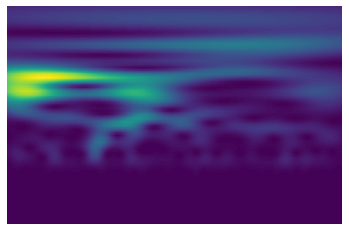

In [91]:
fig, ax = plt.subplots()
T, S = np.meshgrid(wa.time, wa.scales)
ax.set_yscale('log')
plt.axis('off')
ax.contourf(T, S, wa.wavelet_power, 100)
data = fig2img(fig)

In [87]:
data.shape

(432, 288, 4)

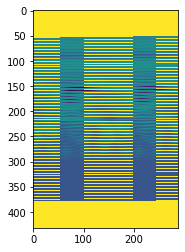

In [88]:
plt.imshow(data[:, :, 2])

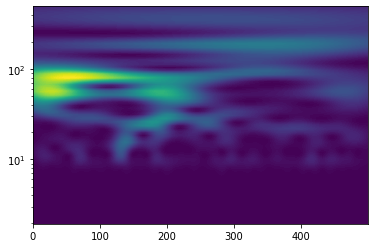

In [71]:
fig, ax = plt.subplots()
T, S = np.meshgrid(wa.time, wa.scales)
ax.set_yscale('log')
X = ax.contourf(T, S, wa.wavelet_power, 100)

In [66]:
X.get_cmap()

In [ ]:
prepare_wavelet(signal)

In [17]:
def extract_features(eeg_path, mep_path):
    epochs = read_eeg(eeg_path)
    epochs, _ = crop_epochs(epochs)
    mep_frames = open_mep_as_df(mep_path)
    if len(epochs) != len(mep_frames):
        raise Exception('MEP frame count (' + str(len(mep_frames)) + ') is not equal to EEG epochs count (' + str(len(epochs)) + ') for ' + eeg_path)
        return
    epoch_features = []
    for i in range(len(epochs)):
        epoch = epochs[i]
        mep = mep_frames[i]
        segments = eeg_path.split('/')
        d = {'sub': segments[2], 'exp': segments[3], 'run': segments[5], 'epoch': i}

        freq, psd = calculate_eeg_frequency(epoch.drop('time', axis=1).values.mean(axis=1))
        d['all_all_max_power_freq'], d['all_all_max_power'] = band_max(freq, psd, 4, 40)
        d['all_delta_max_power_freq'], d['all_delta_max_power'] = band_max(freq, psd, 0, 4)
        d['all_theta_max_power_freq'], d['all_theta_max_power'] = band_max(freq, psd, 4, 8)
        d['all_alpha_max_power_freq'], d['all_alpha_max_power'] = band_max(freq, psd, 8, 16)
        d['all_beta_max_power_freq'], d['all_beta_max_power'] = band_max(freq, psd, 16, 32)
        d['all_gamma_max_power_freq'], d['all_gamma_max_power'] = band_max(freq, psd, 32, 500)

        freq, psd = calculate_eeg_frequency(filter_electrodes(epoch.drop('time', axis=1), 'ltm1').values.mean(axis=1))
        d['ltm1_all_max_power_freq'], d['ltm1_all_max_power'] = band_max(freq, psd, 4, 40)
        d['ltm1_delta_max_power_freq'], d['ltm1_delta_max_power'] = band_max(freq, psd, 0, 4)
        d['ltm1_theta_max_power_freq'], d['ltm1_theta_max_power'] = band_max(freq, psd, 4, 8)
        d['ltm1_alpha_max_power_freq'], d['ltm1_alpha_max_power'] = band_max(freq, psd, 8, 16)
        d['ltm1_beta_max_power_freq'], d['ltm1_beta_max_power'] = band_max(freq, psd, 16, 32)
        d['ltm1_gamma_max_power_freq'], d['ltm1_gamma_max_power'] = band_max(freq, psd, 32, 500)

        freq, psd = calculate_eeg_frequency(filter_electrodes(epoch.drop('time', axis=1), 'rtm1').values.mean(axis=1))
        d['rtm1_all_max_power_freq'], d['rtm1_all_max_power'] = band_max(freq, psd, 4, 40)
        d['rtm1_delta_max_power_freq'], d['rtm1_delta_max_power'] = band_max(freq, psd, 0, 4)
        d['rtm1_theta_max_power_freq'], d['rtm1_theta_max_power'] = band_max(freq, psd, 4, 8)
        d['rtm1_alpha_max_power_freq'], d['rtm1_alpha_max_power'] = band_max(freq, psd, 8, 16)
        d['rtm1_beta_max_power_freq'], d['rtm1_beta_max_power'] = band_max(freq, psd, 16, 32)
        d['rtm1_gamma_max_power_freq'], d['rtm1_gamma_max_power'] = band_max(freq, psd, 32, 500)

        d['area_under_eeg'] = calculate_eeg_area(epoch.drop('time', axis=1))
        d['rtm1_area_under_eeg'] = calculate_eeg_area(filter_electrodes(epoch.drop('time', axis=1), 'rtm1'))
        d['ltm1_area_under_eeg'] = calculate_eeg_area(filter_electrodes(epoch.drop('time', axis=1), 'ltm1'))
        d['all_max_amplitude'] = calculate_eeg_max_amplitude(epoch.drop('time', axis=1))
        d['rtm1_max_amplitude'] = calculate_eeg_max_amplitude(filter_electrodes(epoch.drop('time', axis=1), 'rtm1'))
        d['ltm1_max_amplitude'] = calculate_eeg_max_amplitude(filter_electrodes(epoch.drop('time', axis=1), 'ltm1'))

        d['mep_size'] = calculate_mep_size(mep)
        epoch_features.append(d)
        
        wavelet = {}
        wavelet['all'] = prepare_wavelet(epoch.drop('time', axis=1).values.mean())
        wavelet['ltm1'] = prepare_wavelet(filter_electrodes(epoch.drop('time', axis=1), 'ltm1').values.mean())
        wavelet['rtm1'] = prepare_wavelet(filter_electrodes(epoch.drop('time', axis=1), 'rtm1').values.mean())
        filehandler = open('wavelets/' + segments[2] + '-' + segments[3] + '-' + segments[5] + '-' + i + '.pkl', 'w')
        pickle.dump(wavelet, filehandler)
    return epoch_features

In [18]:
features = []
eegs_to_ignore = ['data/original/sub05/exp01/eeg/SP 110RMT r3/clean.set', 
                  'data/original/sub01/exp01/eeg/SP 110RMT r1/clean.set']
for eeg_path in eegs:
    if (eeg_path in eegs_to_ignore):
        continue
    segments = eeg_path.split('/')
    segments[4] = 'mep'
    segments = segments[:-1]
    mep_path = '/'.join(segments) + '/*.txt'
    mep_path = glob.glob(mep_path)[0]
    features = features + extract_features(eeg_path, mep_path)

Extracting parameters from data/original/sub03/exp01/eeg/SP 110RMT r1/clean.set...
50 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1970: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))


NameError: name 'avg' is not defined

In [ ]:
df = pd.DataFrame(features)
df.tail()

In [ ]:
print(df.shape)
print(df.columns)

In [ ]:
plt.figure(figsize=(14,4))
plt.plot(df['ltm1_all_max_power_freq'], df['mep_size'], '.')
plt.xlabel('Frequency (Hz)')
plt.ylabel('MEP Size')

In [ ]:
plt.figure(figsize=(14,4))
plt.plot(df['ltm1_alpha_max_power_freq'], df['mep_size'], '.')
plt.xlabel('Frequency - alpha band (Hz)')
plt.ylabel('MEP Size')

In [ ]:
plt.figure(figsize=(14,4))
plt.plot(df['ltm1_beta_max_power_freq'], df['mep_size'], '.')
plt.xlabel('Frequency - beta band (Hz)')
plt.ylabel('MEP Size')

In [ ]:
plt.figure(figsize=(14,4))
plt.plot(df['ltm1_gamma_max_power_freq'], df['mep_size'], '.')
plt.xlabel('Frequency - gamma band (Hz)')
plt.ylabel('MEP Size')

In [ ]:
plt.figure(figsize=(14,4))
plt.plot(df['ltm1_delta_max_power_freq'], df['mep_size'], '.')
plt.xlabel('Frequency - delta band (Hz)')
plt.ylabel('MEP Size')

In [ ]:
plt.figure(figsize=(14,4))
plt.plot(df['ltm1_theta_max_power_freq'], df['mep_size'], '.')
plt.xlabel('Frequency - theta band (Hz)')
plt.ylabel('MEP Size')

In [ ]:
df2 = df.groupby(['sub', 'exp', 'run']).mean()
df2.head()

In [ ]:
df2.shape

In [ ]:
plt.figure(figsize=(14,4))
plt.plot(df2['ltm1_all_max_power_freq'], df2['mep_size'], 'o')
plt.xlabel('Frequency (Hz)')
plt.ylabel('MEP Size')

In [ ]:
plt.figure(figsize=(14,4))
plt.plot(df2['ltm1_alpha_max_power_freq'], df2['mep_size'], 'o')
plt.xlabel('Frequency - alpha band (Hz)')
plt.ylabel('MEP Size')

# Frequency bins

In [ ]:
bins = [0, 4, 8, 16, 32, 100]
df3_mean = df.groupby(pd.cut(df['rtm1_all_max_power_freq'], bins)).mean()
df3_max = df.groupby(pd.cut(df['rtm1_all_max_power_freq'], bins)).max()
df3_min = df.groupby(pd.cut(df['rtm1_all_max_power_freq'], bins)).min()
df3_mean['mep_size_mean'] = df3_mean['mep_size']
df3_mean['mep_size_max'] = df3_max['mep_size']
df3_mean['mep_size_min'] = df3_min['mep_size']
df3_mean['rtm1_all_max_power_freq'] = df3_mean.index

In [ ]:
df3_mean[['rtm1_all_max_power_freq', 'mep_size_mean', 'mep_size_max', 'mep_size_min']]

In [ ]:
df4 = df
bins = [0, 4, 8, 16, 32, 100]
df4['bin'] = pd.cut(df4['ltm1_all_max_power_freq'], bins)
df4.head()

fig = plt.figure(figsize=(14, 8))
ax = sns.boxplot(x="bin", y="mep_size", data=df4)
ax.set_xlabel('Frequency Bin')
ax.set_ylabel('MEP Size')
ax.set_title('Left M1 Electrode Frequency Bins vs MEP Size')

In [ ]:
df4 = df
bins = [0, 4, 8, 16, 32, 100]
df4['bin'] = pd.cut(df4['rtm1_all_max_power_freq'], bins)
df4.head()

fig = plt.figure(figsize=(14, 8))
ax = sns.boxplot(x="bin", y="mep_size", data=df4)
ax.set_xlabel('Frequency Bin')
ax.set_ylabel('MEP Size')
ax.set_title('Right M1 Electrode Frequency Bins vs MEP Size')

In [ ]:
df4 = df
bins = [0, 4, 8, 16, 32, 100]
df4['bin'] = pd.cut(df4['all_all_max_power_freq'], bins)
df4.head()

fig = plt.figure(figsize=(14, 8))
ax = sns.boxplot(x="bin", y="mep_size", data=df4)
ax.set_xlabel('Frequency Bin')
ax.set_ylabel('MEP Size')
ax.set_title('All Electrodes Frequency Bins vs MEP Size')

In [ ]:
plt.plot(df4['area_under_eeg'], df4['mep_size'], 'o')
plt.xlabel('Area under EEG - all electrodes')
plt.ylabel('MEP Size')

In [ ]:
plt.plot(df4['rtm1_area_under_eeg'], df4['mep_size'], 'o')
plt.xlabel('Area under EEG - right M1 electrodes')
plt.ylabel('MEP Size')

In [ ]:
plt.plot(df4['ltm1_area_under_eeg'], df4['mep_size'], 'o')
plt.xlabel('Area under EEG - left M1 electrodes')
plt.ylabel('MEP Size')

In [ ]:
plt.plot(df4['all_max_amplitude'], df4['mep_size'], 'o')
plt.xlabel('Max amplitude - all electrodes')
plt.ylabel('MEP Size')

In [ ]:
plt.plot(df4['ltm1_max_amplitude'], df4['mep_size'], 'o')
plt.xlabel('Max amplitude - Left M1 electrodes')
plt.ylabel('MEP Size')

In [ ]:
plt.plot(df4['rtm1_max_amplitude'], df4['mep_size'], 'o')
plt.xlabel('Max amplitude - Right M1 electrodes')
plt.ylabel('MEP Size')

# Keras

In [ ]:
x = df[['all_all_max_power', 'all_all_max_power_freq', 'all_alpha_max_power',
       'all_alpha_max_power_freq', 'all_beta_max_power',
       'all_beta_max_power_freq', 'all_delta_max_power',
       'all_delta_max_power_freq', 'all_gamma_max_power',
       'all_gamma_max_power_freq', 'all_max_amplitude', 'all_theta_max_power',
       'all_theta_max_power_freq', 'area_under_eeg',
       'ltm1_all_max_power', 'ltm1_all_max_power_freq', 'ltm1_alpha_max_power',
       'ltm1_alpha_max_power_freq', 'ltm1_area_under_eeg',
       'ltm1_beta_max_power', 'ltm1_beta_max_power_freq',
       'ltm1_delta_max_power', 'ltm1_delta_max_power_freq',
       'ltm1_gamma_max_power', 'ltm1_gamma_max_power_freq',
       'ltm1_max_amplitude', 'ltm1_theta_max_power',
       'ltm1_theta_max_power_freq', 'rtm1_all_max_power',
       'rtm1_all_max_power_freq', 'rtm1_alpha_max_power',
       'rtm1_alpha_max_power_freq', 'rtm1_area_under_eeg',
       'rtm1_beta_max_power', 'rtm1_beta_max_power_freq',
       'rtm1_delta_max_power', 'rtm1_delta_max_power_freq',
       'rtm1_gamma_max_power', 'rtm1_gamma_max_power_freq',
       'rtm1_max_amplitude', 'rtm1_theta_max_power',
       'rtm1_theta_max_power_freq']]
y = df['mep_size']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=23)